In [34]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Preprocessing data

In [35]:
seed = 42
# Reading data 
data = pd.read_csv("./breast-cancer.txt", sep=",")
print(data.head())

# Dropping missing or non numeric values
nan_rows = data.isna().any(axis=1)
print("Count of missing data: " + str(nan_rows.value_counts()))

# Identifying and removing non numeric data
print(data.info())
data = data.drop("bare_nuclei", axis=1)

# Drop id column
data = data.drop("id", axis=1)

# Create feature and label arrays
y = data["class"]
X = data.drop("class", axis=1)

# Scaling feature matrix
sc = StandardScaler()
X = sc.fit_transform(X)

# Transforming feature vector into bool
y = y.replace({2:False, 4:True})

# Dividing data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        id  clump_thickness  uniform_cell_size  uniform_cell_shape  \
0  1000025                5                  1                   1   
1  1002945                5                  4                   4   
2  1015425                3                  1                   1   
3  1016277                6                  8                   8   
4  1017023                4                  1                   1   

   marginal_adhesion  single_epi_cell_size bare_nuclei  bland_chromation  \
0                  1                     2           1                 3   
1                  5                     7          10                 3   
2                  1                     2           2                 3   
3                  1                     3           4                 3   
4                  3                     2           1                 3   

   normal_nucleoli  mitoses  class  
0                1        1      2  
1                2        1      2  
2          

# Creation of Neuronal Network

In [36]:
from tensorflow.keras.layers import Dense
def get_basic_model(count_nodes=5, count_layers=1):
  model = tf.keras.Sequential()
  for i in range(0,count_layers):
    model.add(Dense(count_nodes, input_shape=(8,)))
  model.add(Dense(1))
    

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model


# Comapring count of nodes for single hidden layer
<img src="WandB_Chart_22-9-2023_14-10-33.png" alt="Loss" />
<br>
In the picture you can see that 5 Nodes lead to a high loss at the beginning and continuing having a worse loss than the networks with more nodes. This is accompanied by the following training accuracy. In the following picture you can see the networks with few nodes (5) and the ones with many (25, 30) starting with a worse training accuracy. While it decreases fast for the larger networks it stays worse for the small network with five nodes.
<img src="WandB_Chart_22-9-2023_14-10-33-acc.png" alt="Accuracy" />

Iteration: 5:
5/5 [==============================] - 0s 2ms/step
Iteration: 10:
5/5 [==============================] - 0s 2ms/step
Iteration: 15:
5/5 [==============================] - 0s 1ms/step
Iteration: 20:
5/5 [==============================] - 0s 4ms/step
Iteration: 25:
5/5 [==============================] - 0s 2ms/step
Iteration: 30:
5/5 [==============================] - 0s 5ms/step


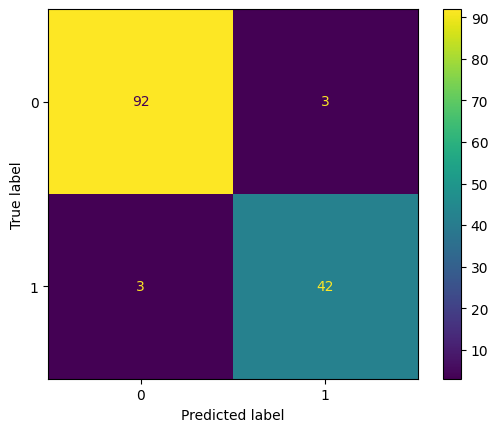

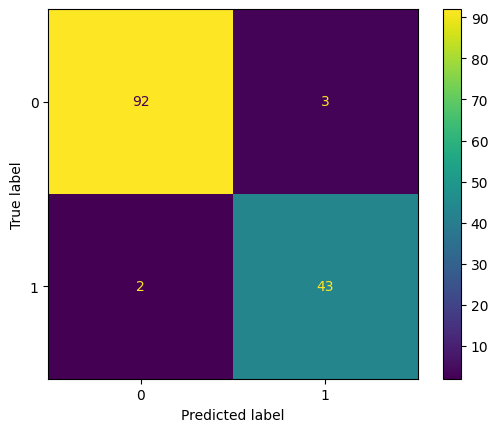

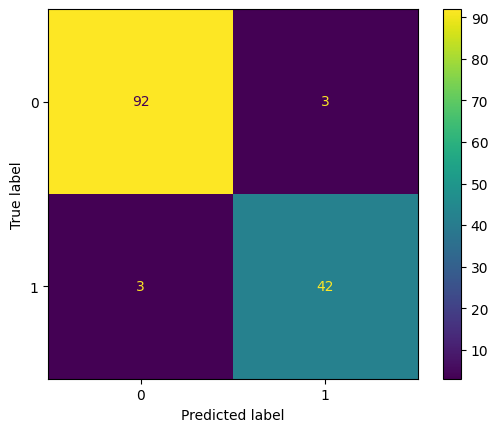

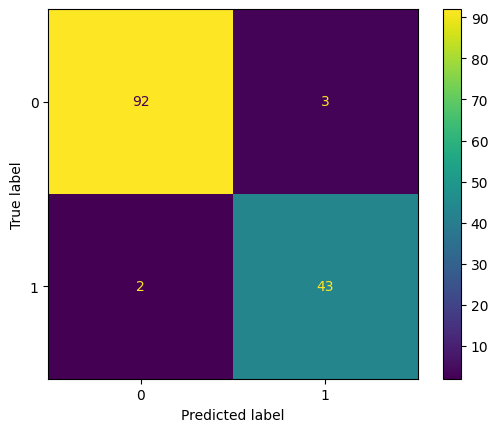

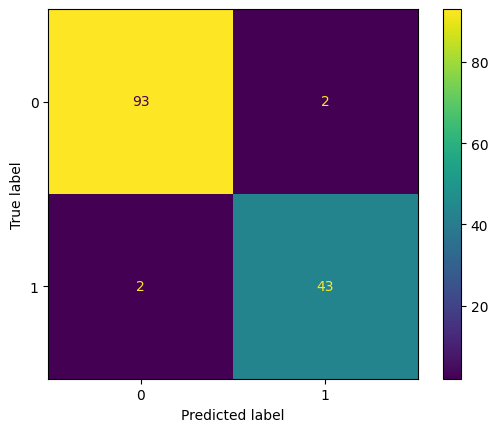

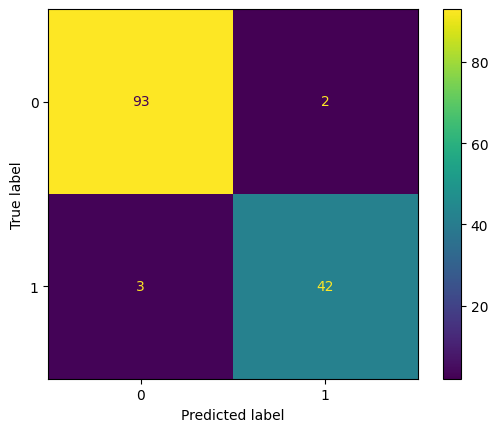

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()
def to_bool(x):
    if x>=0:
        return True
    return False

y_test = y_test.reset_index(drop=True)

for i in range(5,31,5):
    print(f"Iteration: {i}:")
    # wandb.init(project='test-tumor-classification', name=f"One Layer, {i} Nodes")
    model = get_basic_model(count_nodes=i)
    model.fit(X_train, y_train, epochs=15, batch_size=16, verbose=0) #, validation_data=(X_test, y_test), callbacks=[WandbMetricsLogger()])
    predictions = model.predict(X_test)
    predictions = np.apply_along_axis(to_bool,axis=1, arr=predictions)
    cm_ens = confusion_matrix(y_true=y_test, y_pred=predictions)
    disp_ens = ConfusionMatrixDisplay(cm_ens)
    disp_ens.plot()
    # wandb.finish()

# Evaluating count of hidden layers
Node size is determined by accuracy on training set
<img src="layers_loss.png" alt="Loss" />

<img src="layers_acc.png" alt="Accuracy" />

Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 1ms/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 2ms/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 2ms/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 2ms/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 2ms/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 671us/step
Iteration: 5:
Iteration: 10:
Iteration: 15:
Iteration: 20:
Iteration: 25:
Iteration: 30:
5/5 [==============================] - 0s 1ms/step
Iteration: 5:
Iter

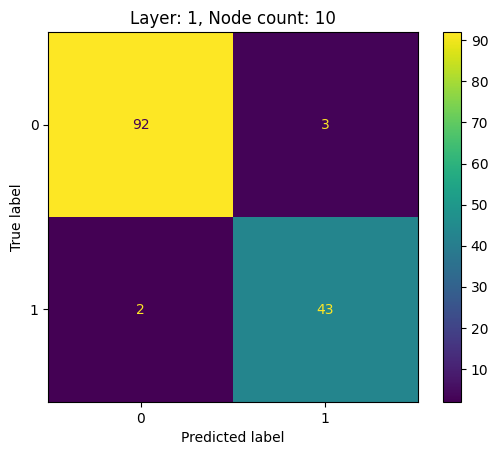

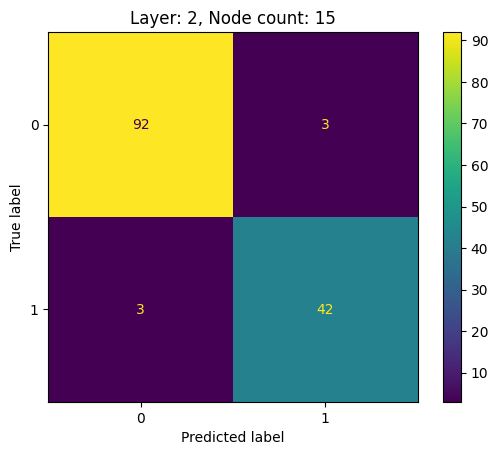

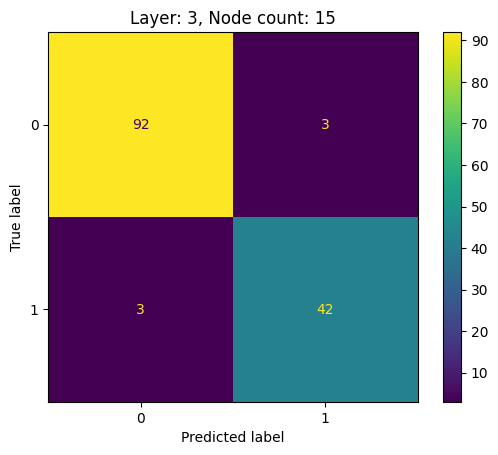

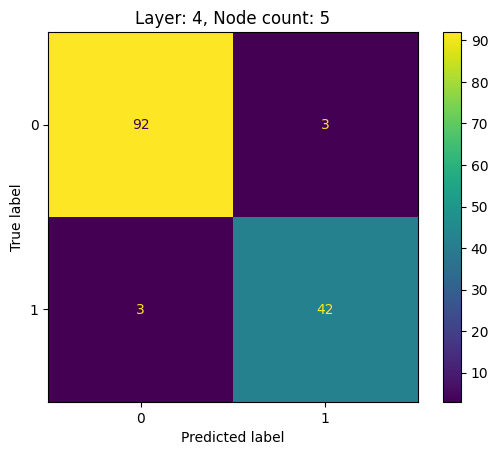

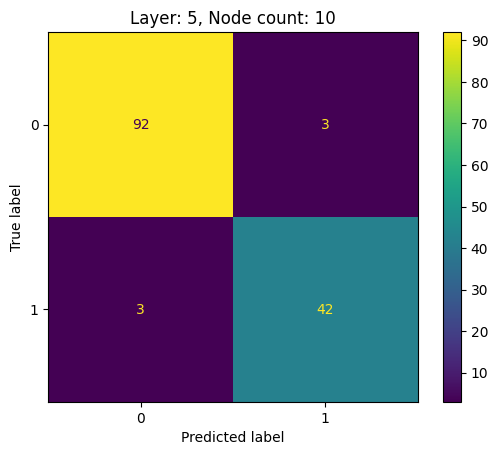

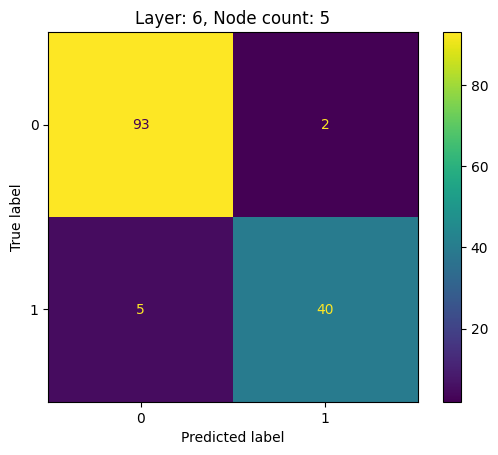

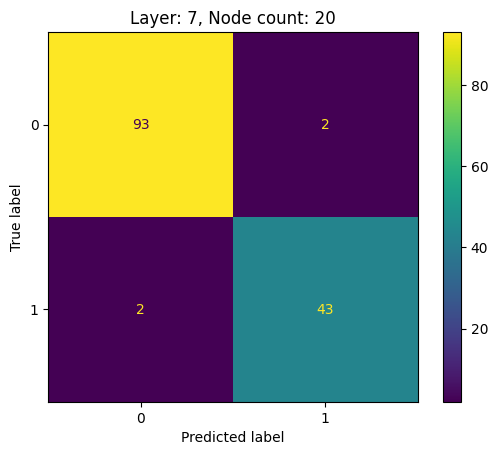

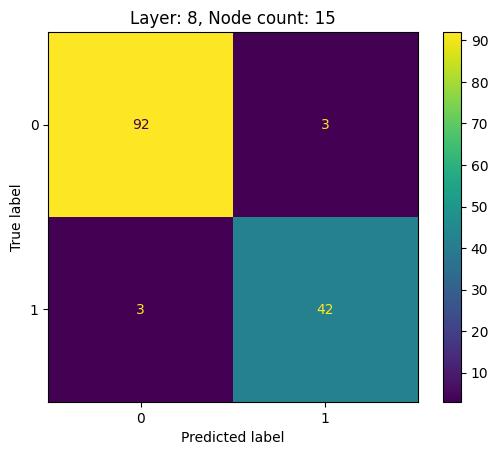

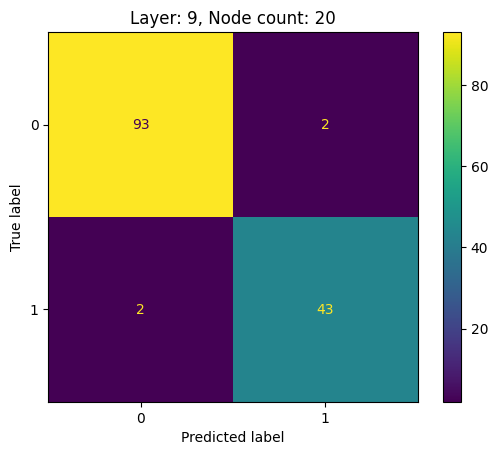

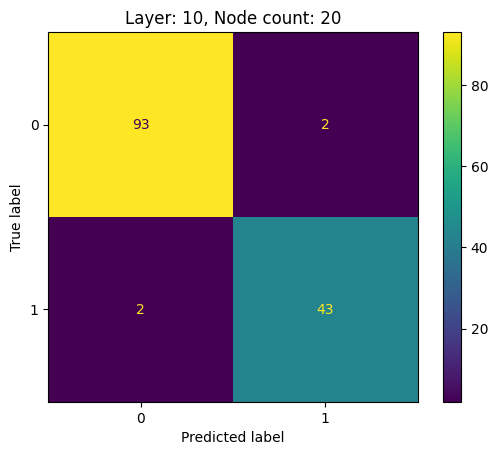

In [38]:
node_counts = [0 for x in range(1,12)]
plots = []
for layer in range(1,11):
    best_acc = 0
    best_model = None
    for i in range(5,31,5):
        # wandb.init(project='test-tumor-classification-2', name=f"{layer} Layer, {i} Nodes")
        print(f"Iteration: {i}:")
        model = get_basic_model(count_nodes=i)
        model.fit(X_train, y_train, epochs=15, batch_size=16, verbose=0) # , validation_data=(X_test, y_test), callbacks=[WandbMetricsLogger()])
        acc = model.get_metrics_result()["accuracy"]
        if best_acc<acc:
            node_counts[layer] = i
            best_acc = acc
            best_model = model
    # wandb.run.summary["best_node_cnt"] = f"Layer: {layer}, Nodes: {node_counts[layer]}"
    # wandb.finish()
    predictions = best_model.predict(X_test)
    predictions = np.apply_along_axis(to_bool,axis=1, arr=predictions)
    cm_ens = confusion_matrix(y_true=y_test, y_pred=predictions)
    disp_ens = ConfusionMatrixDisplay(cm_ens)
    disp_ens.plot()
    disp_ens.ax_.set_title(f"Layer: {layer}, Node count: {node_counts[layer]}")
    plots.append(disp_ens)
print(node_counts)

The results on the test set are similar for the neural networks with the different layers and node counts.

[10, 15, 15, 5, 10, 5, 20, 15, 20, 20]


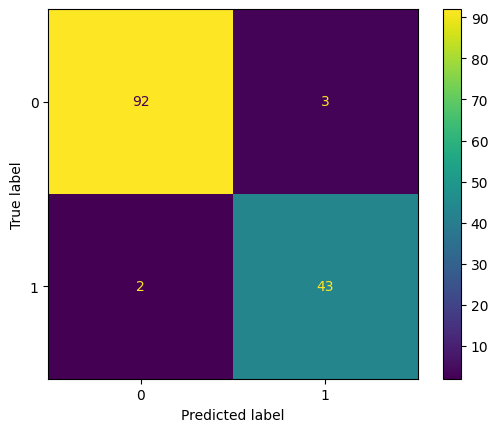

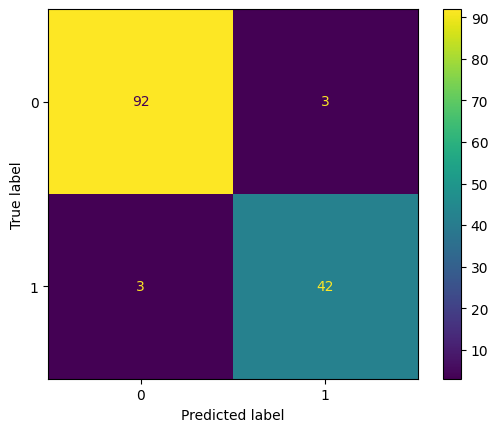

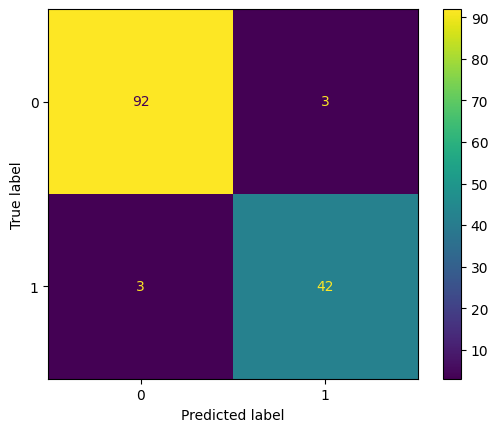

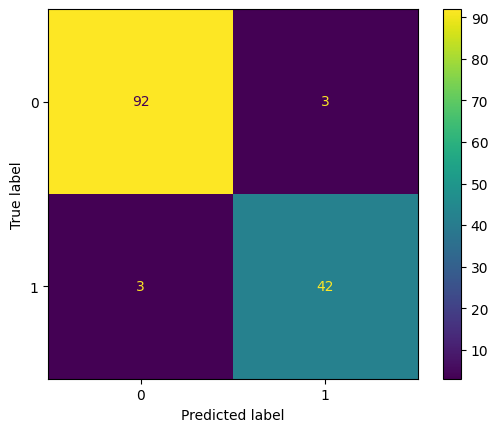

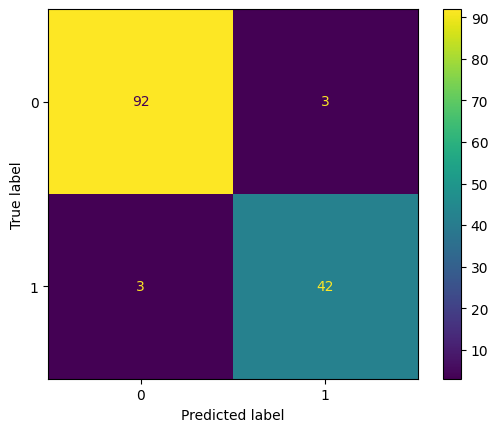

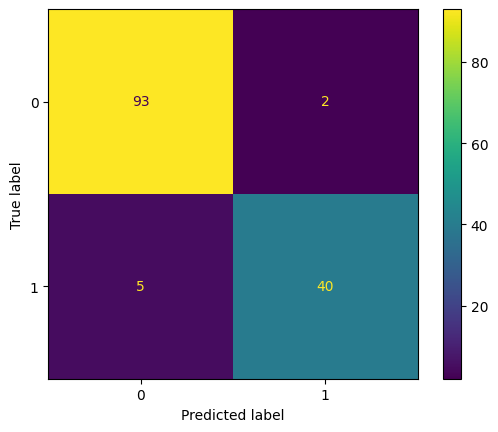

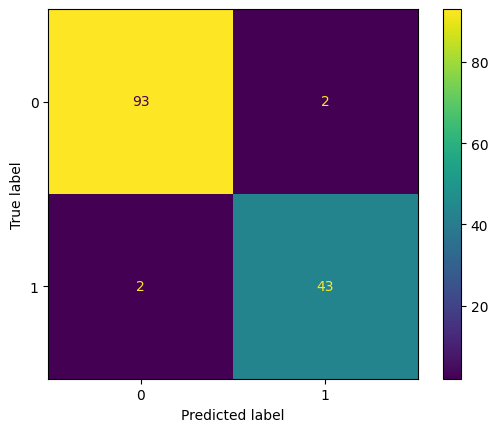

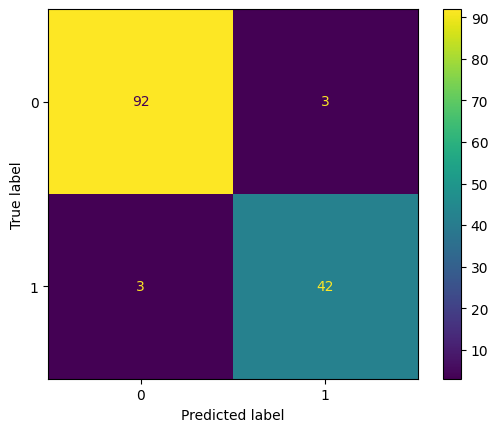

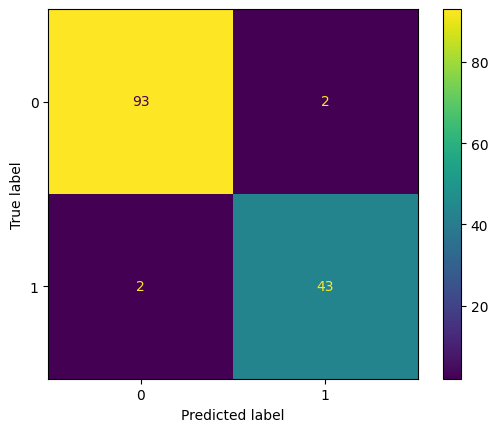

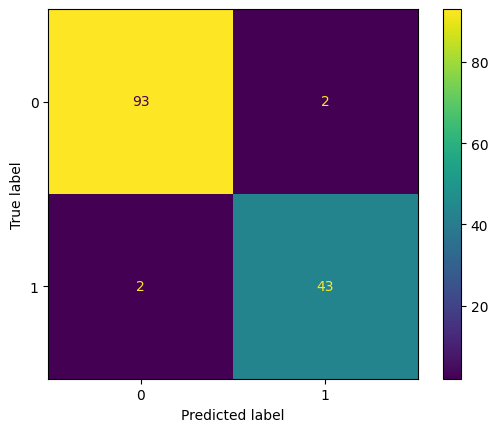

In [41]:
print(node_counts[1:])
for plot in plots:
    plot.plot()

# 7) Network with 4 hidden layers and 10 neurons incl. Drop-Out